# English NER comparison

So, Aaron & I were running tests on the named-entity-recognition in [Basis,](http://www.basistech.com/) [AlchemyAPI,](http://www.alchemyapi.com/) [MITIE,](https://github.com/mit-nlp/MITIE) and [SpaCy.]()

# Sample corpus

Jeff hooked us up with a [bunch of text](http://giantoakmemex.s3.amazonaws.com/english.json.gz) (link goes to file) from Wikipedia articles. Since there aren't any gold standard annotations associated with this, we're just looking at relative performance of the different extractors - what one found that a different one didn't, etc.

# Results

## Aaron's aggregate Jaccard Similarities

Aaron munged the lists of entities from Basis, SpaCy, and MITIE that I sent him with his Alchemy results and calculated inter-group Jaccard similarities. That gives us this little table:

NER 1 | NER 2 | Jaccard
:--- |:--- | ---:
Basis | MITIE | 0.4129
Basis | SpaCy | 0.3040
MITIE | SpaCy | 0.2855
Alchemy | Basis | 0.0302
Alchemy | MITIE | 0.0280
Alchemy | SpaCy | 0.0217

These groups are finding very different populations. However, this bears a little bit of additional investigation: many of the entities found by different classifiers are often similar; they differ because of odd bits of prepended syntax or capitalization: things that we'd likely clean up in post-processing. As such, I try to sort this out with a little bit of cleaning below, and then look at the unique entities pulled by each extractor. I also check the difference in levenshtein 

In [1]:
def recurser(x, lower=False):
    """
    Kill "the"s, "a"s, "an"s, possesive "s"s, and wrapping punctuation and whitespace
    (Regexes are silly but easy.)
    Replace numbers with "<NUM>"
    :param str x:
    :param bool lower:
    :return str:
    """
    import re
    from string import punctuation
    try:
        new_x = re.sub('[0-9]*(\,?[0-9]*)*\.?[0-9]+', '<NUM>', x)
        new_x = re.sub('([\#\.\-]?\<NUM\>)+', '<NUM>', new_x)
        new_x = new_x.replace('(<NUM>)', '<NUM>')
        new_x = re.sub('\'s$', '', 
                       re.sub('^[Aa]n? ', '',
                              re.sub('^[Tt]he ', '',
                                     new_x.strip(punctuation).strip())))
        if lower:
            new_x = new_x.lower()
    except (AttributeError, TypeError):
        return ''
    
    return new_x

def simple_entity_cleaner(x, lower=False):
    """
    :param str x:
    :param bool lower
    :return str:
    """
    new_x = recurser(x, lower)
    while new_x != x:
        x = new_x
        new_x = recurser(x, lower)    
    return new_x

def get_min_substring_delta(ngram, other_ngrams):
    """
    Get the shortest substring distance between ngram and all members of other_ngrams
    If ngram is shorter than the other_ngram, the value is positive.
    If ngram is longer, the value is negative.
    :param str ngram:
    :param list|set other_ngrams:
    :return int:
    """
    min_dist = 1000000000
    len_ngram = len(ngram)
    for ngram_two in other_ngrams:
        if ngram_two.find(ngram) > -1:
            new_dist = len_ngram - len(ngram_two)
            if new_dist < 2:
                return new_dist
        elif ngram.find(ngram_two) > -1:
            new_dist = -1 * (len(ngram_two) - len_ngram)
        else:
            continue
            
        if abs(new_dist) < abs(min_dist):
            min_dist = new_dist
            
    return min_dist

In [2]:
jsns = json.load(open('jaccardScores.json', 'r'))
new_uniques = {}
for key in ['AlchemyAPI', 'basis', 'mitie', 'spacy']:
    ents = jsns['unique_list'][key]
    new_uniques[key] = set([simple_entity_cleaner(x) for x in ents]) - {'', '<NUM>'}
    print('{} | {} | {}'.format(key, len(set(ents)), len(new_uniques[key])))

AlchemyAPI | 17722 | 17255
basis | 1302 | 1286
mitie | 1432 | 1431
spacy | 1310 | 1226


In [3]:
for key in new_uniques:
    print('=====')
    print(key)
    print('-----')
    print(pd.Series(sorted(list(new_uniques[key]))).head(5))

=====
spacy
-----
0                  ABC
1                  ABH
2                  ADA
3              AOL Inc
4    ARIA Music Awards
dtype: object
=====
AlchemyAPI
-----
0              A
1    A&M Records
2           A. C
3        A. Gunn
4     A. H. Cobb
dtype: object
=====
basis
-----
0      A
1    ABC
2    ABH
3    AFP
4    AMG
dtype: object
=====
mitie
-----
0            ABC
1            ABH
2           ADMD
3        AOL Inc
4    APRA Awards
dtype: object


In [4]:
def print_summary_stats(set_dict, key):
    """
    Print summary vocab stats for set_dict[key]
    :param dict set_dict: Dictionary of sets of vocabuary
    :param str key: Key for which to get  vocab stats
    """
    other_set = set()
    for key_two in set_dict:
        if key_two != key:
            other_set.update(set_dict[key_two])
    key_uniques = set_dict[key] - other_set
    substring_dist = pd.Series([x
                                for x in [get_min_substring_delta(y, other_set)
                                          for y in key_uniques
                                          if len(y) > 4]
                                if x != 1000000000])

    print('{} entities'.format(len(new_uniques[key])))
    for x in sorted(list(new_uniques[key]))[:5]:
        print('  {}'.format(x))
    print('----')
    print('{} unique entities'.format(len(key_uniques)))
    for x in sorted(list(key_uniques))[:5]:
        print('  {}'.format(x))
    print('----')
    print('{} other entities'.format(len(other_set)))
    print('----')
    print('----')
    print(substring_dist.ix[substring_dist < 0].describe())
    print('----')
    print(substring_dist.ix[substring_dist < 0].value_counts().head(5))
    print('----')
    print('----')
    print(substring_dist.ix[substring_dist > -1].describe())
    print('----')
    print(substring_dist.ix[substring_dist > -1].value_counts().head(5))

In [5]:
print_summary_stats(new_uniques, 'AlchemyAPI')

17255 entities
  A
  A&M Records
  A. C
  A. Gunn
  A. H. Cobb
----
16499 unique entities
  A&M Records
  A. C
  A. Gunn
  A. H. Cobb
  A. J
----
2258 other entities
----
----
count    427.000000
mean     -12.625293
std        8.243086
min      -50.000000
25%      -16.000000
50%      -11.000000
75%       -7.000000
max       -1.000000
dtype: float64
----
-14    33
-5     33
-6     29
-8     29
-9     28
dtype: int64
----
----
count    8310.000000
mean       14.598556
std         9.292060
min         1.000000
25%         8.000000
50%        12.000000
75%        19.000000
max       102.000000
dtype: float64
----
8     551
9     551
7     516
11    494
10    481
dtype: int64


In [6]:
print_summary_stats(new_uniques, 'basis')

1286 entities
  A
  ABC
  ABH
  AFP
  AMG
----
236 unique entities
  AFP
  ARP
  Adelaide, Australia
  Alejandro
  Alfredo "Al Mineo" Manfredi
----
18521 other entities
----
----
count    63.000000
mean    -11.317460
std       6.455369
min     -30.000000
25%     -14.500000
50%     -10.000000
75%      -6.000000
max      -1.000000
dtype: float64
----
-5     8
-9     6
-11    5
-8     5
-6     4
dtype: int64
----
----
count    123.000000
mean      10.658537
std        7.266394
min        1.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       50.000000
dtype: float64
----
5    15
8    14
6    12
7    12
9    11
dtype: int64


In [7]:
print_summary_stats(new_uniques, 'mitie')

1431 entities
  ABC
  ABH
  ADMD
  AOL Inc
  APRA Awards
----
407 unique entities
  APRA Awards
  APRA Music Awards
  ARIA Music Award
  Aboriginal-based
  Abscam—sometimes
----
18350 other entities
----
----
count    93.000000
mean    -17.322581
std      13.891788
min     -73.000000
25%     -21.000000
50%     -13.000000
75%      -8.000000
max      -1.000000
dtype: float64
----
-14    8
-6     7
-12    6
-8     6
-10    6
dtype: int64
----
----
count    186.000000
mean      10.188172
std        6.799211
min        1.000000
25%        6.000000
50%        8.000000
75%       12.000000
max       48.000000
dtype: float64
----
6     27
7     23
10    19
8     18
5     13
dtype: int64


In [8]:
print_summary_stats(new_uniques, 'spacy')

1226 entities
  ABC
  ABH
  ADA
  AOL Inc
  ARIA Music Awards
----
295 unique entities
  ADA
  ARIA Music Awards
  Academy Awards
  Accepted Accounting Principles
  Accountability
----
18462 other entities
----
----
count    71.000000
mean    -12.887324
std      10.214205
min     -50.000000
25%     -14.500000
50%      -9.000000
75%      -6.500000
max      -3.000000
dtype: float64
----
-7     7
-8     7
-4     6
-6     6
-14    5
dtype: int64
----
----
count    173.000000
mean      12.271676
std        7.392733
min        1.000000
25%        7.000000
50%       11.000000
75%       16.000000
max       57.000000
dtype: float64
----
5     14
13    14
10    11
8     10
9     10
dtype: int64


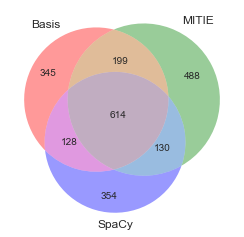

In [9]:
from matplotlib_venn import venn3
import seaborn as sns
sns.set_context('notebook')
%matplotlib inline

venn3([new_uniques['basis'], new_uniques['mitie'], new_uniques['spacy']], set_labels=['Basis', 'MITIE', 'SpaCy'])

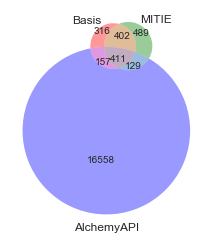

In [10]:
venn3([new_uniques['basis'], new_uniques['mitie'], new_uniques['AlchemyAPI']], set_labels=['Basis', 'MITIE', 'AlchemyAPI'])

# My look at the data

I was a bit curious about Aaron's aggregated scores, so took a look at the raw JSON he'd received.
Per the Alchemy API, he could only run 1,000 documents through the program. He also used the default for *number* of entities to extract, meaning that he only got back at most fifty per document.
Looking at the numbers for MITIE, Basis, and SpaCy,
we have *way* more than fifty entities per document on average within that first 1000:

 |Basis | | MITIE | | SpaCy | | Alchemy | |
---:| ---:| ---:| ---:| ---:| ---:| ---:
 | **All** | **Unique** | **All** | **Unique** | **All** | **Unique** | **All** | **Unique**
**Mean** | 171.78 | 101.16 | 157.62 | 94.06 | 207.84 | 133.10 | 35.57 | 34.93
**STD** | 253.21 | 129.00 | 224.37 | 117.98 | 303.57 | 169.60 | 17.23 | 16.81
**Median** | 79.5| 56 | 77 | 55 | 100 | 76 | 48.5 | 46

These counts are pretty skewed, but it still means that Alchemy is returning undercounts of entities for a number of results.

Aaron was looking at the munged unique data, so I'm going to concentrate on a per document average here. What I want is the *average delta per document* for each tool.

In [11]:
from itertools import combinations
from collections import defaultdict

jsns = json.load(open('post_basis_mitie_spacy_english.json', 'r'))
alc_jsns = json.load(open('20160331_output.json', 'r'))

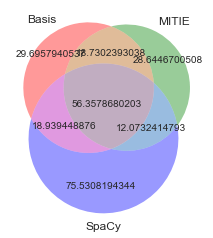

In [12]:
ent_groups = defaultdict(list)

# key_set = {'alchemy', 'basis', 'mitie', 'spacy'}
key_set = {'basis', 'mitie', 'spacy'}
# for i in range(1000):
for i in range(len(jsns)):
    ents = dict()
    for key in ['mitie', 'basis', 'spacy']:
        ents[key] = set(x[1] for x in jsns[i][key]['full_text_ents'])
        # ents['alchemy'] = set(x['text'] for x in alc_jsns[i]['entities'])
        
    for group_size in range(1,len(key_set)+1):
        for key_group in combinations(key_set, group_size):
            unique_keys = set(ents[key_group[0]])
            for key in key_group[1:]:
                unique_keys &= ents[key]

            out_group = key_set - set(key_group)
            for key in out_group:
                unique_keys -= ents[key]

            ent_groups[','.join(sorted(list(key_group)))].append(len(unique_keys))

venn3(subsets=[pd.Series(ent_groups[x]).describe()['mean']
               for x in ['basis', 'mitie', 'basis,mitie',
                         'spacy', 'basis,spacy', 'mitie,spacy',
                         'basis,mitie,spacy']],
      set_labels=['Basis', 'MITIE', 'SpaCy'])

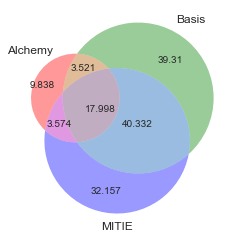

In [13]:
ent_groups = defaultdict(list)

key_set = {'alchemy', 'basis', 'mitie'}
for i in range(1000):
    ents = dict()
    for key in ['mitie', 'basis', 'spacy']:
        ents[key] = set(x[1] for x in jsns[i][key]['full_text_ents'])
        ents['alchemy'] = set(x['text'] for x in alc_jsns[i]['entities'])
        
    for group_size in range(1,len(key_set)+1):
        for key_group in combinations(key_set, group_size):
            unique_keys = set(ents[key_group[0]])
            for key in key_group[1:]:
                unique_keys &= ents[key]

            out_group = key_set - set(key_group)
            for key in out_group:
                unique_keys -= ents[key]

            ent_groups[','.join(sorted(list(key_group)))].append(len(unique_keys))

venn3(subsets=[pd.Series(ent_groups[x]).describe()['mean']
               for x in ['alchemy', 'basis', 'alchemy,basis',
                         'mitie', 'alchemy,mitie', 'basis,mitie',
                         'alchemy,basis,mitie']],
      set_labels=['Alchemy', 'Basis', 'MITIE'])

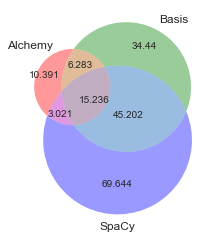

In [14]:
ent_groups = defaultdict(list)

key_set = {'alchemy', 'basis', 'spacy'}
for i in range(1000):
    ents = dict()
    for key in ['mitie', 'basis', 'spacy']:
        ents[key] = set(x[1] for x in jsns[i][key]['full_text_ents'])
        ents['alchemy'] = set(x['text'] for x in alc_jsns[i]['entities'])
        
    for group_size in range(1,len(key_set)+1):
        for key_group in combinations(key_set, group_size):
            unique_keys = set(ents[key_group[0]])
            for key in key_group[1:]:
                unique_keys &= ents[key]

            out_group = key_set - set(key_group)
            for key in out_group:
                unique_keys -= ents[key]

            ent_groups[','.join(sorted(list(key_group)))].append(len(unique_keys))

venn3(subsets=[pd.Series(ent_groups[x]).describe()['mean']
               for x in ['alchemy', 'basis', 'alchemy,basis',
                         'spacy', 'alchemy,spacy', 'basis,spacy',
                         'alchemy,basis,spacy']],
      set_labels=['Alchemy', 'Basis', 'SpaCy'])

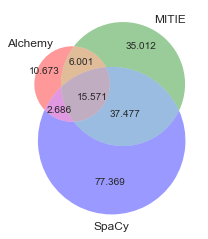

In [15]:
ent_groups = defaultdict(list)

# key_set = {'alchemy', 'basis', 'mitie', 'spacy'}
key_set = {'alchemy', 'mitie', 'spacy'}
for i in range(1000):
    ents = dict()
    for key in ['mitie', 'basis', 'spacy']:
        ents[key] = set(x[1] for x in jsns[i][key]['full_text_ents'])
        ents['alchemy'] = set(x['text'] for x in alc_jsns[i]['entities'])
        
    for group_size in range(1,len(key_set)+1):
        for key_group in combinations(key_set, group_size):
            unique_keys = set(ents[key_group[0]])
            for key in key_group[1:]:
                unique_keys &= ents[key]

            out_group = key_set - set(key_group)
            for key in out_group:
                unique_keys -= ents[key]

            ent_groups[','.join(sorted(list(key_group)))].append(len(unique_keys))

venn3(subsets=[pd.Series(ent_groups[x]).describe()['mean']
               for x in ['alchemy', 'mitie', 'alchemy,mitie',
                         'spacy', 'alchemy,spacy', 'mitie,spacy',
                         'alchemy,mitie,spacy']],
      set_labels=['Alchemy', 'MITIE', 'SpaCy'])

Bearing in mind that these counts are screwed up due to the Alchemy entity caps, it seems like SpaCy is, on average, finding the greatest number of unique entities.

# Issues

The issues with these tests (and they are biggies):

## The Alchemy API Caps

Those make it really hard to compare performance across the different documents. It would be worth re-running the test (shouldn't take too long) pulling down the same results b

## Gold-standard data

We don't have any gold-standard entity extraction data: we need validated ground truth for difinitive answers.

## Foreign-language data

We've only been testing on entity extraction in English. If we want to know about performance on other languages, we need data on other languages.

## Mimicking GOST &/or Dozer's internal post-processing pipeline

I did some degree of post-processing on the data extacted by Aaron, using my own system for cleaning up extracted entities. Really, we should be using the post-extraction pipelines followed by GOST and Dozer, since those are the ones that matter in practice.